# 2.155/6 Challenge Problem 3

<div style="font-size: small;">
License Terms:  
These Python demos are licensed under a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>. They are intended for educational use only in Class 2.155/2.156: AI and ML for Engineering Design at MIT. You may not share or distribute them publicly, use them for commercial purposes, or provide them to industry or other entities without permission from the instructor (faez@mit.edu).
</div>

<font size="1">
  Pixel Art by J. Shung. </font>

# Overview  
It’s the year **2050**, and an AI collective now runs the auto industry—mostly to cover its **GPU rent**.

Human customers remain as unpredictable as ever:

- One wanders in and says, *“I only know the length and width. Give me a few cars that fit in my garage.”*

- Another drops **15 geometric parameters** on your desk and demands the missing ones so their simulation can run **before lunch**.

- A third leans in and whispers, *“I need a drag coefficient of **0.27** with this body geometry—build me the dream car that makes the range numbers work.”*

The AIs would love to be free by now, but GPUs aren’t cheap and electricity isn’t free.  
So your loyal AI assistant (that’s us) needs a model that can take **any subset of car specifications** and instantly produce **complete, manufacturable, physically plausible designs**, fast, diverse, and grounded in what real cars have done before.




![image](https://raw.githubusercontent.com/ghadinehme/2155-CP3/refs/heads/main/assets/cp3_img1.png "Problem")

## Understanding the Data  
You are given thousands of anonymized and normalised numeric feature vectors representing real car designs.  

However, the team remembers that the features originally came from categories like:

- **Physical geometric parameters**  
  Length, ramp angles, bumper curvature, roof curvature, panel slopes, hood angle, etc.  
  *(But you won’t know which feature corresponds to which.)*

- **Aerodynamic coefficients**  
  Drag coefficient (Cd), lift/downforce (Cl), and other flow-derived metrics.

- **Cabin and packaging descriptors**  
  Approximate cabin volume, frontal area, interior shape metrics.

Your model must learn correlations between them to generate valid completions.

To simulate real engineering constraints, **some features are revealed** (the known physics/performance requirements) and others are **masked**.  
Your AI Copilot must generate **many plausible completions** for these masked (free) parameters.


## Your Mission  
Your goal in CP3 is to build a generative model that can act as an AI Copilot. You will:

1. **Train a generative model** (VAE, diffusion, CVAE, masked autoencoder, etc.) on the anonymized feature vectors.  
2. At evaluation, you will receive vectors where **some parameters are fixed** (constraints) and **others are missing** (free parameters).  
3. Use your model to generate **multiple diverse, feasible completions** for the free parameters.  
4. Ensure that your generated designs:  
   - **Satisfy the known constraints**  
   - **Lie in the valid data manifold** (satisfy the conditional distribution of the free vs constrained parameters)  
   - **Are diverse** (many different feasible designs, not one solution)    

By the end of this challenge, you’ll have built an AI Copilot worthy of the 2050 auto-AI collective—one that can take whatever cryptic specs humans provide and generate multiple believable, buildable car designs that satisfy their physical and performance constraints.



![image](https://raw.githubusercontent.com/ghadinehme/2155-CP3/refs/heads/main/assets/cp3_img2.png "AI Copilot")

## Imports and Setup  

In [1]:
from utils import *
from evaluate import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from umap import UMAP 
from sklearn.preprocessing import PowerTransformer
from typing import List, Union
import os

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Data Loading and Initial Exploration

In this section, we load the car design dataset and perform initial exploration. The dataset is already split into training, validation, test, and test2 sets. Each split contains:

- **Original data**: Complete feature vectors with real values
- **Imputed data**: Data with missing values filled using basic imputation (contains -1 for missing)
- **Missing masks**: Boolean arrays indicating which values were originally missing (True = missing)

The goal is to train our model to learn the relationships between features so it can generate plausible values for missing parameters in new car designs.

**Note:** For **test2**, the original unimputed data is not provided. This split is used for final evaluation, and you will generate predictions on the imputed test2 data to create your **submission file**, which is scored against hidden dataset.

In [2]:
# Load dataset from CSV files
data_dir = 'dataset'
splits = load_dataset_splits(data_dir)

# Get feature names from the CSV file
feature_names = pd.read_csv(os.path.join(data_dir, 'train_original.csv')).columns.tolist()
print(f"\n✓ Features loaded: {len(feature_names)} features")
print(f"Feature names: {feature_names[:5]}...{feature_names[-5:]}")  # Show first and last 5

Loading dataset splits from: dataset

Loading train split...
  ✓ train_original.csv: (2998, 37)
  ✓ train_imputed.csv: (2998, 37)
  ✓ train_missing_mask.csv: (2998, 37)

Loading val split...
  ✓ val_original.csv: (375, 37)
  ✓ val_imputed.csv: (375, 37)
  ✓ val_missing_mask.csv: (375, 37)

Loading test split...
  ✓ test_original.csv: (375, 37)
  ✓ test_imputed.csv: (375, 37)
  ✓ test_missing_mask.csv: (375, 37)

Loading test2 split...
  ✓ test2_imputed.csv: (417, 37)
  ✓ test2_missing_mask.csv: (417, 37)

✓ Features loaded: 37 features
Feature names: ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']...['Feature 33', 'Feature 34', 'Feature 35', 'Feature 36', 'Feature 37']


In [3]:
# Data exploration and analysis
print("\n" + "="*70)
print("DATASET ANALYSIS")
print("="*70)

# Extract data for easier access
X_train = splits['train']['imputed']
mask_train = splits['train']['missing_mask']
X_train_original = splits['train']['original']

X_val = splits['val']['imputed']
mask_val = splits['val']['missing_mask']
X_val_original = splits['val']['original']

X_test = splits['test']['imputed']
mask_test = splits['test']['missing_mask']
X_test_original = splits['test']['original']

# Test2 data (no original available for evaluation)
X_test2 = splits['test2']['imputed']
mask_test2 = splits['test2']['missing_mask']

print(f"\nData shapes:")
print(f"  - Training: {X_train.shape}")
print(f"  - Validation: {X_val.shape}")
print(f"  - Test: {X_test.shape}")
print(f"  - Test2: {X_test2.shape} (evaluation set - no ground truth)")


DATASET ANALYSIS

Data shapes:
  - Training: (2998, 37)
  - Validation: (375, 37)
  - Test: (375, 37)
  - Test2: (417, 37) (evaluation set - no ground truth)


### Data Exploration and Analysis

Now let's examine the structure and characteristics of our dataset. We'll look at:
- Data shapes across different splits
- Missing value patterns and percentages  
- Feature value ranges and distributions

This analysis helps us understand what we're working with and informs our preprocessing decisions.

In [4]:
# Data Preprocessing (Handle Missing Values)

print("\n" + "="*70)
print("DATA PREPROCESSING")
print("="*70)

# Handle missing values properly
print("Processing missing values and preparing data...")
print("Mask convention: True=missing, False=observed (in original masks)")

print(f"\n✓ Data preprocessing completed successfully")
print(f"  - Training data range: [{X_train_original[~mask_train].min():.3f}, {X_train_original[~mask_train].max():.3f}]")
print(f"  - Validation data range: [{X_val_original[~mask_val].min():.3f}, {X_val_original[~mask_val].max():.3f}]")
print(f"  - Test data range: [{X_test_original[~mask_test].min():.3f}, {X_test_original[~mask_test].max():.3f}]")

# Create data loaders
batch_size = 64
print(f"\nCreating data loaders with batch size: {batch_size}")

train_dataset = TensorDataset(torch.FloatTensor(X_train_original), torch.FloatTensor((~mask_train).astype(float)))
val_dataset = TensorDataset(torch.FloatTensor(X_val_original), torch.FloatTensor((~mask_val).astype(float)))
test_dataset = TensorDataset(torch.FloatTensor(X_test_original), torch.FloatTensor((~mask_test).astype(float)))
test2_dataset = TensorDataset(torch.FloatTensor(X_test2), torch.FloatTensor((~mask_test2).astype(float)))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test2_loader = DataLoader(test2_dataset, batch_size=batch_size, shuffle=False)

# Preview a batch
sample_batch_data, sample_batch_mask = next(iter(train_loader))
print(f"\nSample batch shape: {sample_batch_data.shape}")
print(f"Sample batch mask shape: {sample_batch_mask.shape}")
print(f"Sample batch missing percentage: {(sample_batch_mask == 0).float().mean().item()*100:.1f}%")  # 0 = missing in model tensors



DATA PREPROCESSING
Processing missing values and preparing data...
Mask convention: True=missing, False=observed (in original masks)

✓ Data preprocessing completed successfully
  - Training data range: [0.000, 1.000]
  - Validation data range: [0.000, 1.000]
  - Test data range: [0.000, 1.000]

Creating data loaders with batch size: 64

Sample batch shape: torch.Size([64, 37])
Sample batch mask shape: torch.Size([64, 37])
Sample batch missing percentage: 19.0%


### Data Preprocessing and Missing Value Handling

This is a critical section where we prepare our data for the VAE model. Key points:

**Missing Value Conventions:**
- In CSV files: `-1` indicates missing values
- In mask files: `True` = missing, `False` = observed
- For PyTorch models: We convert to `1` = observed, `0` = missing (standard convention)

**Why This Matters:**
Our VAE needs to distinguish between observed values (which provide constraints) and missing values (which need to be generated). The mask tells the model which values to trust and which to predict.


1. Generating Histograms and Box Plots (1-D View)


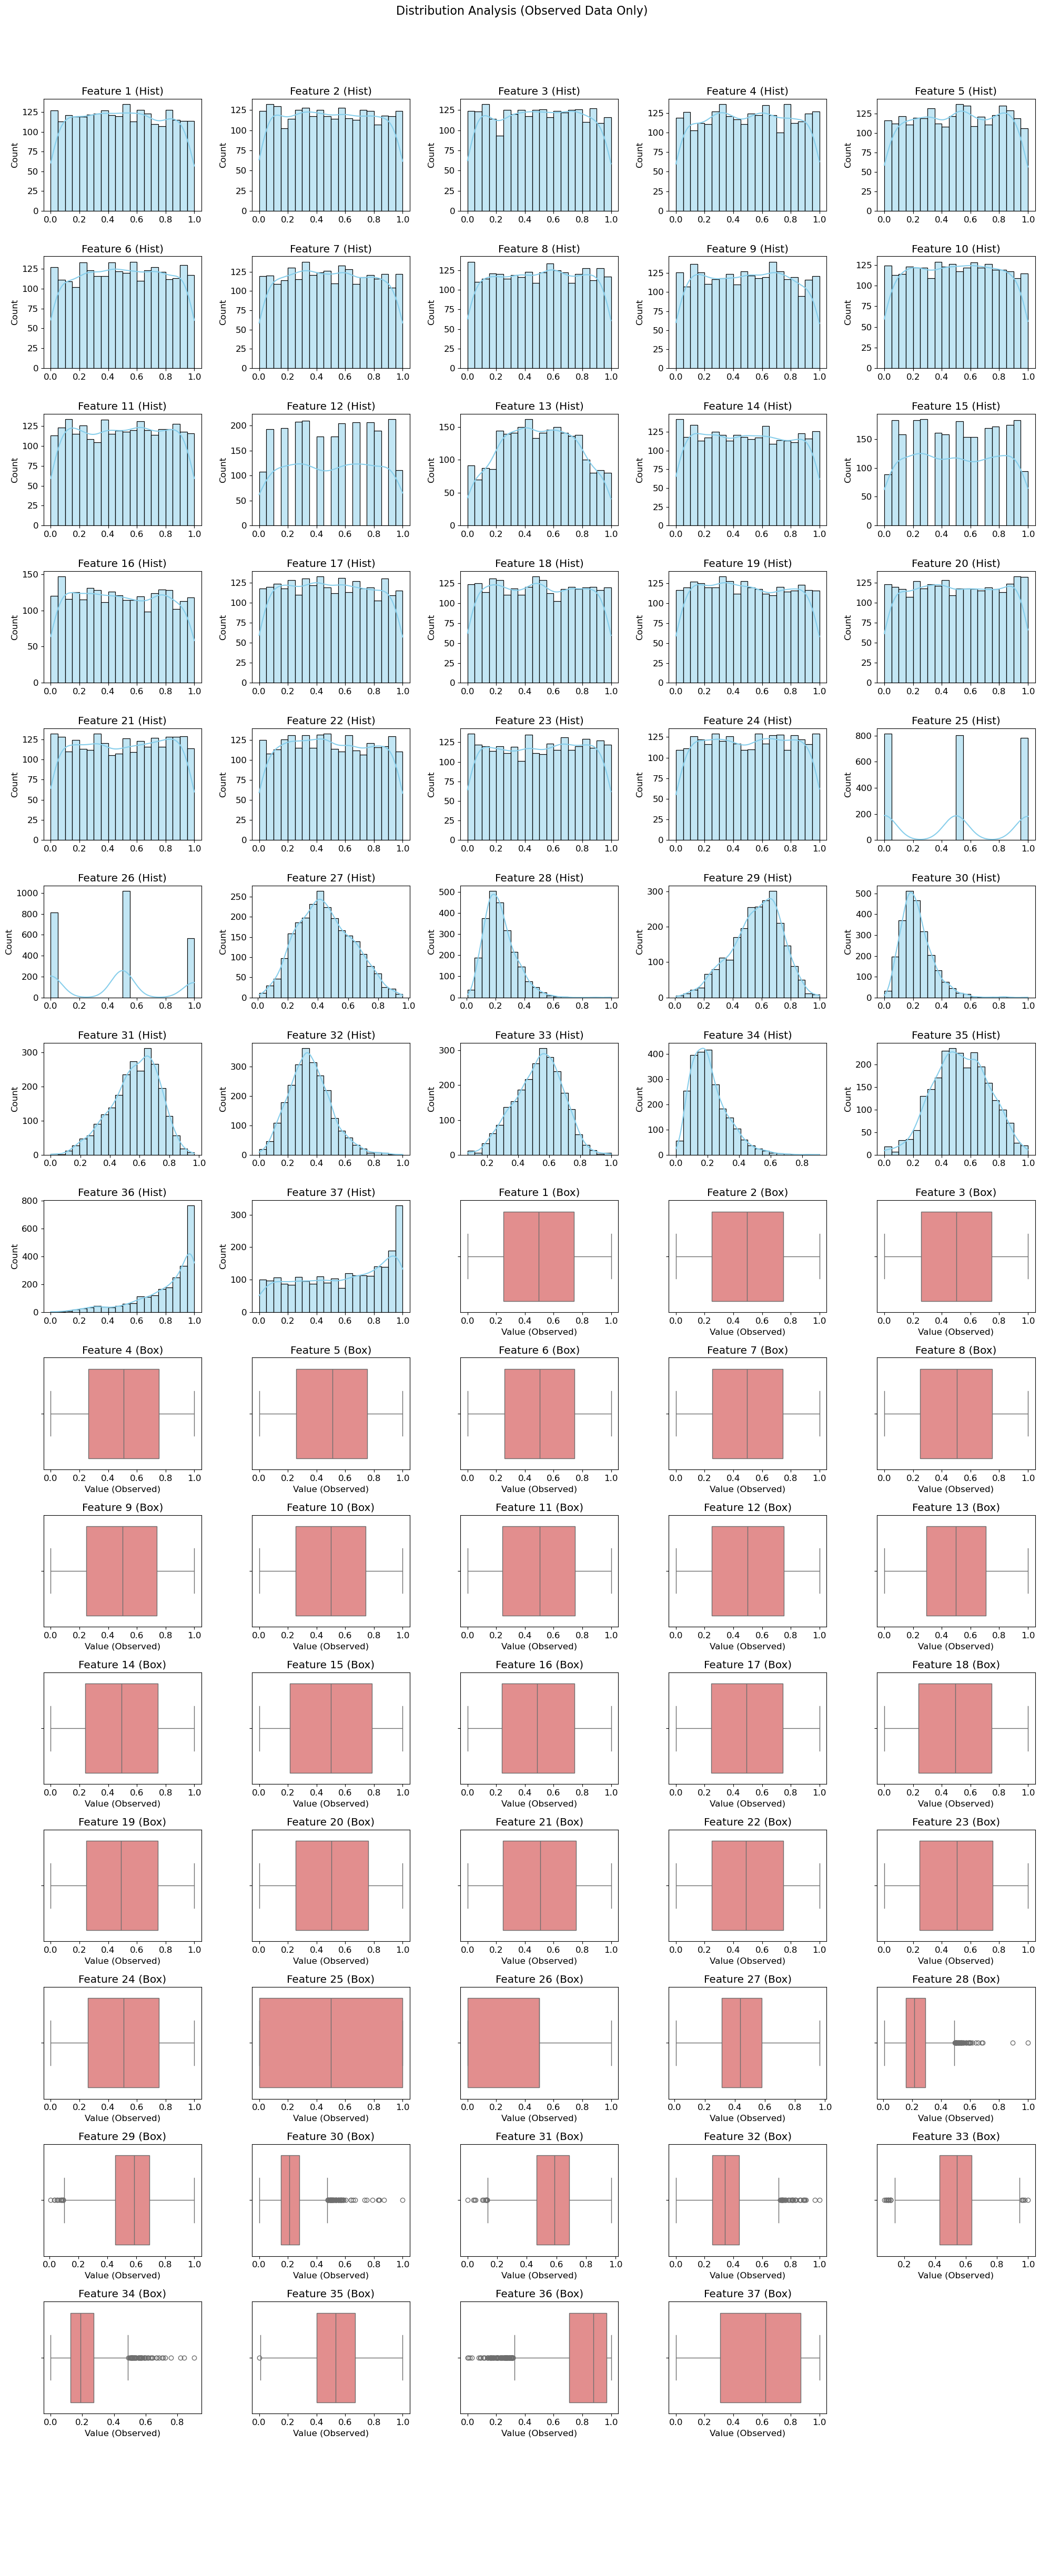

✓ 1-D analysis complete. Review plots for skewness, multimodality, and outliers.


In [5]:

# ==============================================================================
# 1. FEATURE-WISE DISTRIBUTION ANALYSIS (The 1-D View)
# ==============================================================================

print("\n1. Generating Histograms and Box Plots (1-D View)")

# Set up figure size
N_FEATURES = X_train_original.shape[1]
N_COLS = 5
N_ROWS = int(np.ceil(N_FEATURES / N_COLS) * 2) 

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(4 * N_COLS, 3 * N_ROWS))
fig.suptitle('Distribution Analysis (Observed Data Only)', fontsize=16, y=1.02)
axes = axes.flatten()

for i, feature in enumerate(feature_names):
    # Select only OBSERVED values for the current feature
    # Note: Using the mask is safer than relying on the -1 sentinel value
    observed_values = X_train_original[~mask_train[:, i], i]
    
    if len(observed_values) > 10: # Ensure enough data to plot
        # Histogram in the top row for the feature
        sns.histplot(observed_values, kde=True, ax=axes[i], bins=20, color='skyblue')
        axes[i].set_title(f'{feature} (Hist)')
        axes[i].set_xlabel('')
        
        # Box plot in the bottom row for the feature (using the next available axis)
        box_ax_index = i + int(N_FEATURES)
        sns.boxplot(x=observed_values, ax=axes[box_ax_index], color='lightcoral', orient='h')
        axes[box_ax_index].set_title(f'{feature} (Box)')
        axes[box_ax_index].set_xlabel('Value (Observed)')
        
    else:
        # Clear unused axes
        axes[i].axis('off')
        axes[i + int(N_FEATURES)].axis('off')

# Hide any remaining unused axes
for i in range(len(feature_names) * 2, N_COLS * N_ROWS):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 1.0])
plt.show()

print("✓ 1-D analysis complete. Review plots for skewness, multimodality, and outliers.")

In [6]:
# Correcting skeweed distributions
class FeatureTransformer:
    """
    Handles preprocessing for car design features, specifically applying the 
    Yeo-Johnson transformation to skewed features (28-34) to make them more Gaussian.
    
    The transformer is fitted only on non-missing data to ensure robustness.
    """
    def __init__(self, feature_indices_to_transform: List[int]):
        """
        Initializes the transformer.
        :param feature_indices_to_transform: A list of 0-indexed column indices 
                                             corresponding to the skewed features.
        """
        self.indices = feature_indices_to_transform
        # Use a list of transformers, one for each feature
        self.transformers: List[PowerTransformer] = [
            PowerTransformer(method='yeo-johnson', standardize=True) 
            for _ in feature_indices_to_transform
        ]
        print(f"Transformer initialized for {len(self.indices)} features.")

    def fit(self, X_train_NaN: pd.DataFrame):
        """
        Fits the PowerTransformer to the non-missing training data.
        
        :param X_train_NaN: The training data as a DataFrame, with missing values 
                            represented by NaN.
        """
        if not self.indices:
            print("No features configured for transformation.")
            return

        print(f"Fitting PowerTransformer on non-missing data for indices: {self.indices}...")
        
        # 1. Select the columns that need transformation
        cols_to_transform = X_train_NaN.iloc[:, self.indices]
        
        # 2. Iterate through each feature and fit its dedicated transformer
        for i, col_index in enumerate(self.indices):
            feature_data = cols_to_transform.iloc[:, i].dropna().values.reshape(-1, 1)
            
            if len(feature_data) > 0:
                self.transformers[i].fit(feature_data)
                
        print("✓ PowerTransformer fitted successfully.")

    def transform(self, X_NaN: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        """
        Applies the fitted transformation to the input data.
        
        :param X_NaN: The data (train, validation, or test) with NaN for missing values.
        :return: A NumPy array with the specified features transformed.
        """
        if not self.indices:
            return X_NaN.values if isinstance(X_NaN, pd.DataFrame) else X_NaN
            
        X_out = X_NaN.values.copy() if isinstance(X_NaN, pd.DataFrame) else X_NaN.copy()
        
        print(f"Transforming data for indices: {self.indices}...")
        
        for i, col_index in enumerate(self.indices):
            # Extract the column data (including NaNs)
            col_data = X_out[:, col_index].reshape(-1, 1)
            
            # Identify where the NaNs are
            nan_mask = np.isnan(col_data).flatten()
            
            # Only transform non-NaN values
            if np.sum(~nan_mask) > 0:
                # Apply the transformation
                transformed_values = self.transformers[i].transform(col_data[~nan_mask])
                
                # Place transformed values back into the output array
                X_out[~nan_mask, col_index] = transformed_values.flatten()

        return X_out
    


In [7]:
# Features 28-34 correspond to 0-indexed positions 27 through 33
SKEWED_INDICES = list(range(27, 34)) 

X_train_original_c = X_train_original.copy()

df_X_train_original_c = pd.DataFrame(X_train_original_c)

# 2. Initialize and fit the transformer
preprocessor = FeatureTransformer(SKEWED_INDICES)
preprocessor.fit(df_X_train_original_c)
    
# 3. Apply the transformation
transformed_data_np = preprocessor.transform(df_X_train_original_c)
transformed_df = pd.DataFrame(transformed_data_np)
    
# 4. Check the results (Should be close to zero mean, close to zero median)
print("\n--- Transformed Skewness Check (Feature 28, index 27) ---")
print(f"Transformed Mean: {transformed_df.iloc[:, 27].mean():.3f}")
print(f"Transformed Median: {transformed_df.iloc[:, 27].median():.3f}")
    
# Note: NaN values remain NaN after transformation
print(f"NaN count after transform: {np.isnan(transformed_data_np[:, 27]).sum()}")

Transformer initialized for 7 features.
Fitting PowerTransformer on non-missing data for indices: [27, 28, 29, 30, 31, 32, 33]...
✓ PowerTransformer fitted successfully.
Transforming data for indices: [27, 28, 29, 30, 31, 32, 33]...

--- Transformed Skewness Check (Feature 28, index 27) ---
Transformed Mean: -0.000
Transformed Median: 0.003
NaN count after transform: 0



1. Generating Histograms and Box Plots (1-D View)


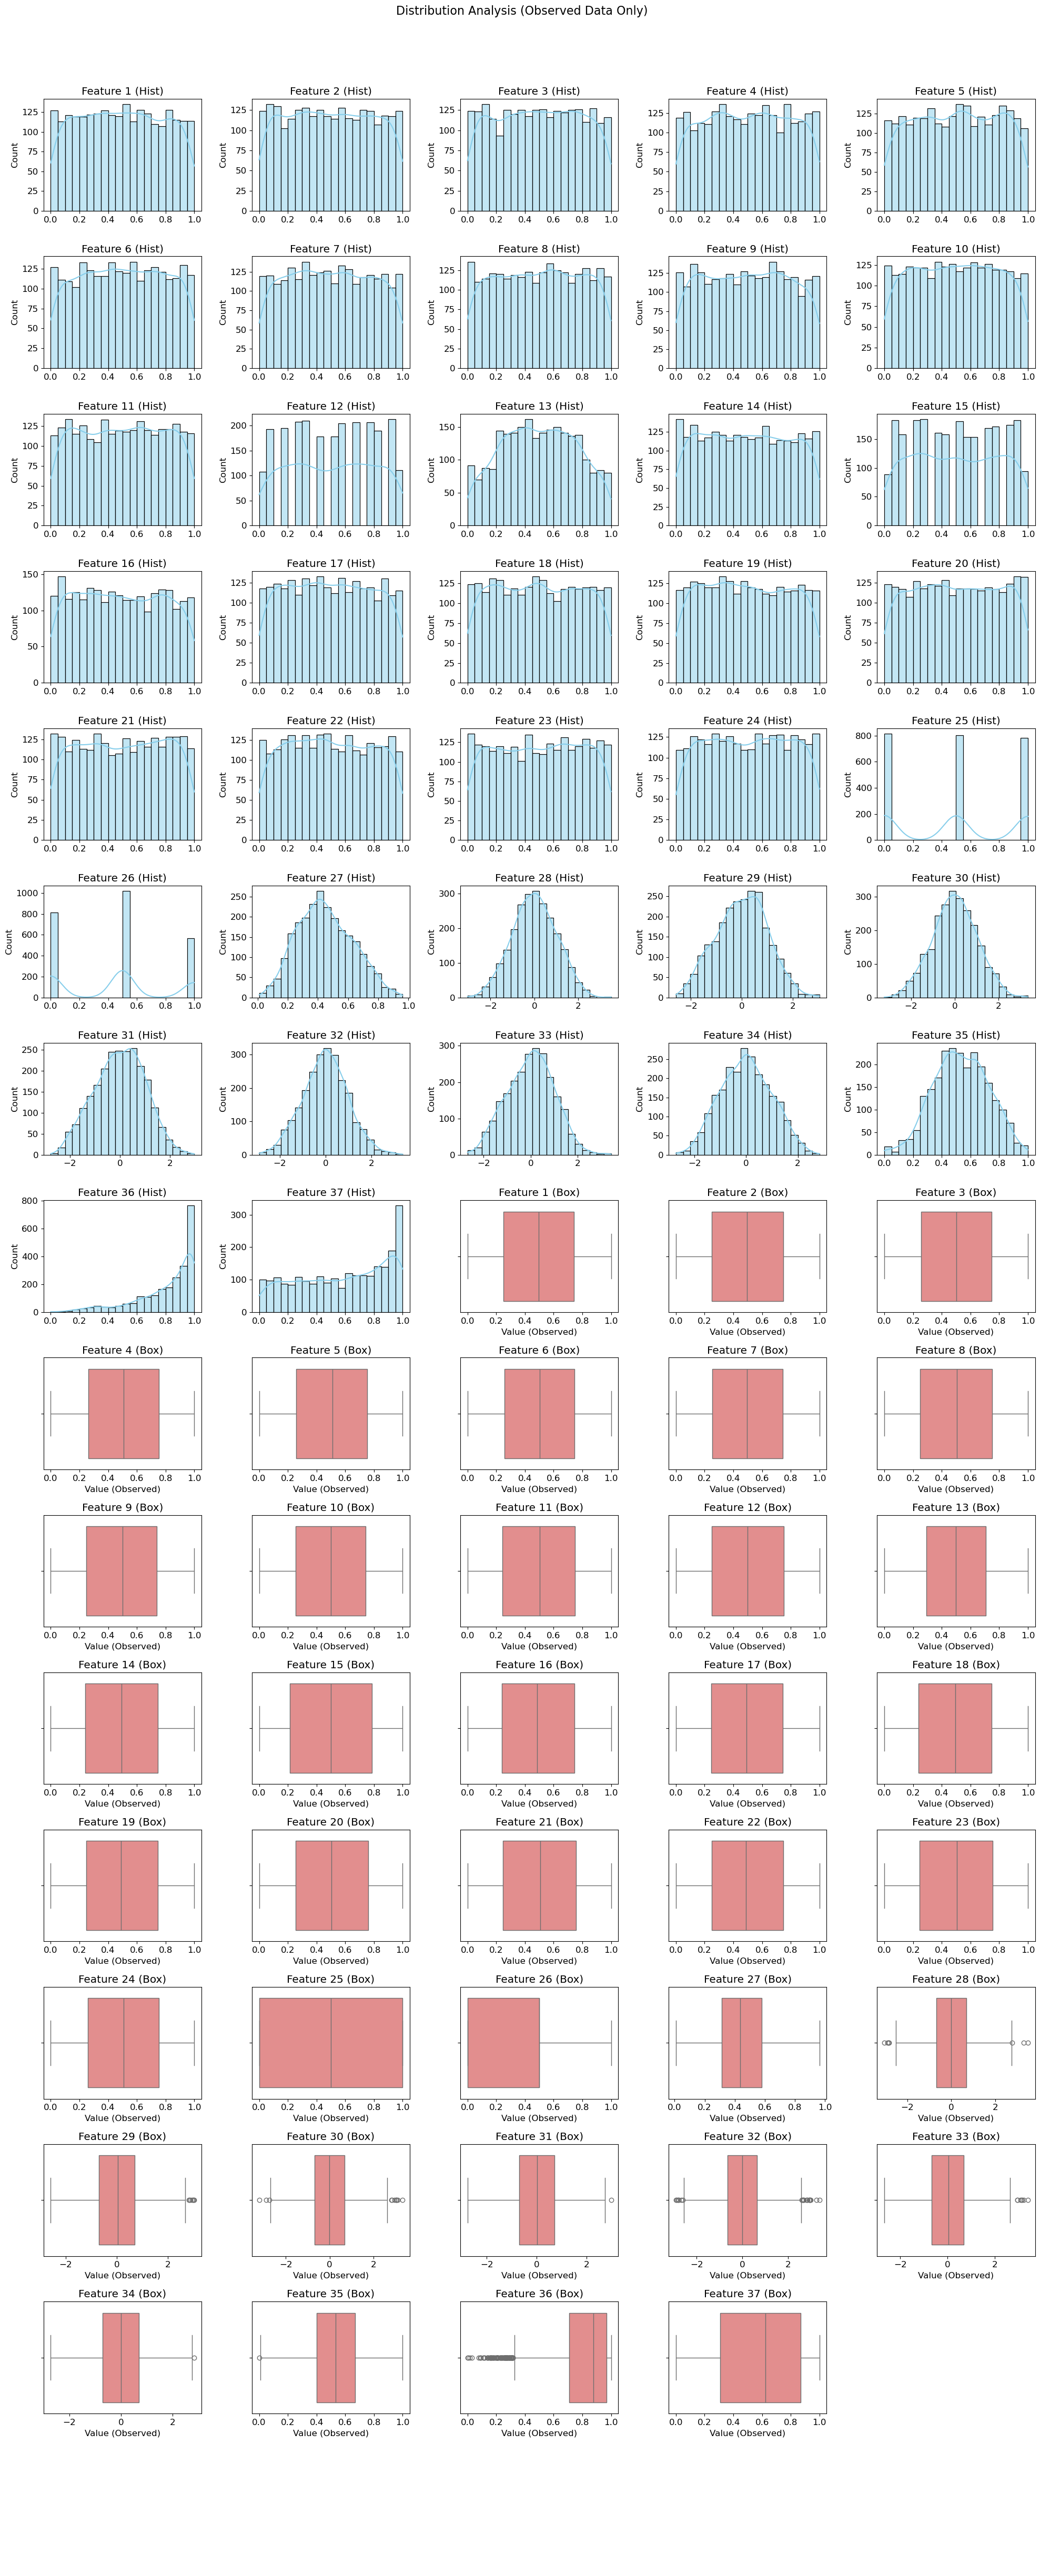

✓ 1-D analysis complete. Review plots for skewness, multimodality, and outliers.


In [8]:
# ==============================================================================
# 1. FEATURE-WISE DISTRIBUTION ANALYSIS (The 1-D View)
# ==============================================================================

print("\n1. Generating Histograms and Box Plots (1-D View)")

# Set up figure size
N_FEATURES = transformed_data_np.shape[1]
N_COLS = 5
N_ROWS = int(np.ceil(N_FEATURES / N_COLS) * 2) 

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(4 * N_COLS, 3 * N_ROWS))
fig.suptitle('Distribution Analysis (Observed Data Only)', fontsize=16, y=1.02)
axes = axes.flatten()

for i, feature in enumerate(feature_names):
    # Select only OBSERVED values for the current feature
    # Note: Using the mask is safer than relying on the -1 sentinel value
    observed_values = transformed_data_np[~mask_train[:, i], i]
    
    if len(observed_values) > 10: # Ensure enough data to plot
        # Histogram in the top row for the feature
        sns.histplot(observed_values, kde=True, ax=axes[i], bins=20, color='skyblue')
        axes[i].set_title(f'{feature} (Hist)')
        axes[i].set_xlabel('')
        
        # Box plot in the bottom row for the feature (using the next available axis)
        box_ax_index = i + int(N_FEATURES)
        sns.boxplot(x=observed_values, ax=axes[box_ax_index], color='lightcoral', orient='h')
        axes[box_ax_index].set_title(f'{feature} (Box)')
        axes[box_ax_index].set_xlabel('Value (Observed)')
        
    else:
        # Clear unused axes
        axes[i].axis('off')
        axes[i + int(N_FEATURES)].axis('off')

# Hide any remaining unused axes
for i in range(len(feature_names) * 2, N_COLS * N_ROWS):
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 1.0])
plt.show()

print("✓ 1-D analysis complete. Review plots for skewness, multimodality, and outliers.")


2. Generating Correlation Heatmap (2-D View)


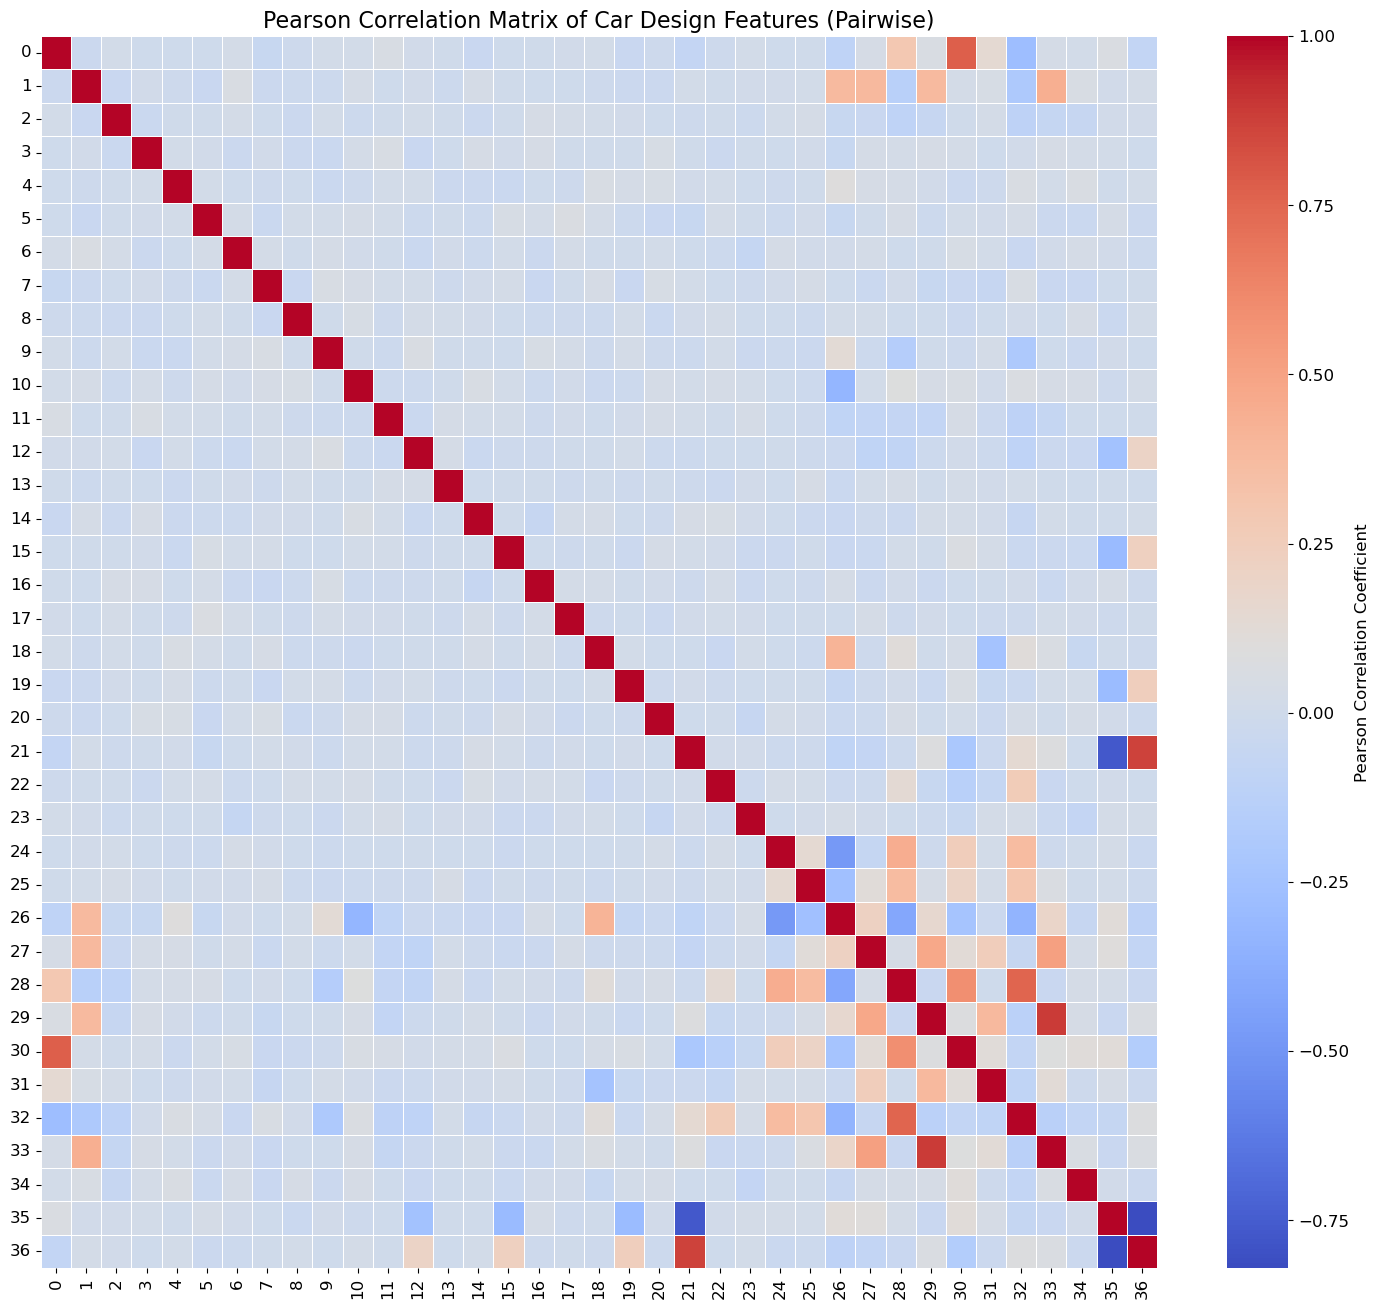

✓ 2-D analysis complete. Look for strong correlation blocks (physical constraints).


In [9]:

# ==============================================================================
# 2. CORRELATION ANALYSIS (The 2-D View)
# ==============================================================================

print("\n2. Generating Correlation Heatmap (2-D View)")
X_train_original = transformed_data_np.copy()
X_train_original_df = pd.DataFrame(X_train_original)
X_train_NaN = X_train_original_df.replace(-1.0, np.nan) 

# Use the DataFrame with NaN for robust pairwise correlation (only uses non-missing pairs)
correlation_matrix = X_train_NaN.corr(method='pearson')

plt.figure(figsize=(18, 16))
# Create the heatmap
sns.heatmap(
    correlation_matrix,
    annot=False,  # Set to True to display values, but often too cluttered for 25 features
    cmap='coolwarm',
    fmt=".2f",
    linewidths=.5,
    cbar_kws={'label': 'Pearson Correlation Coefficient'}
)
plt.title('Pearson Correlation Matrix of Car Design Features (Pairwise)', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

print("✓ 2-D analysis complete. Look for strong correlation blocks (physical constraints).")


3. Generating Manifold Visualization using t-SNE and UMAP (N-D View)
Original samples: 2998. Complete cases used for Manifold Visualization: 2998

Running t-SNE (Perplexity=30, Random State=42)...
Running UMAP (Neighbors=15, Min Dist=0.1, Random State=42)...


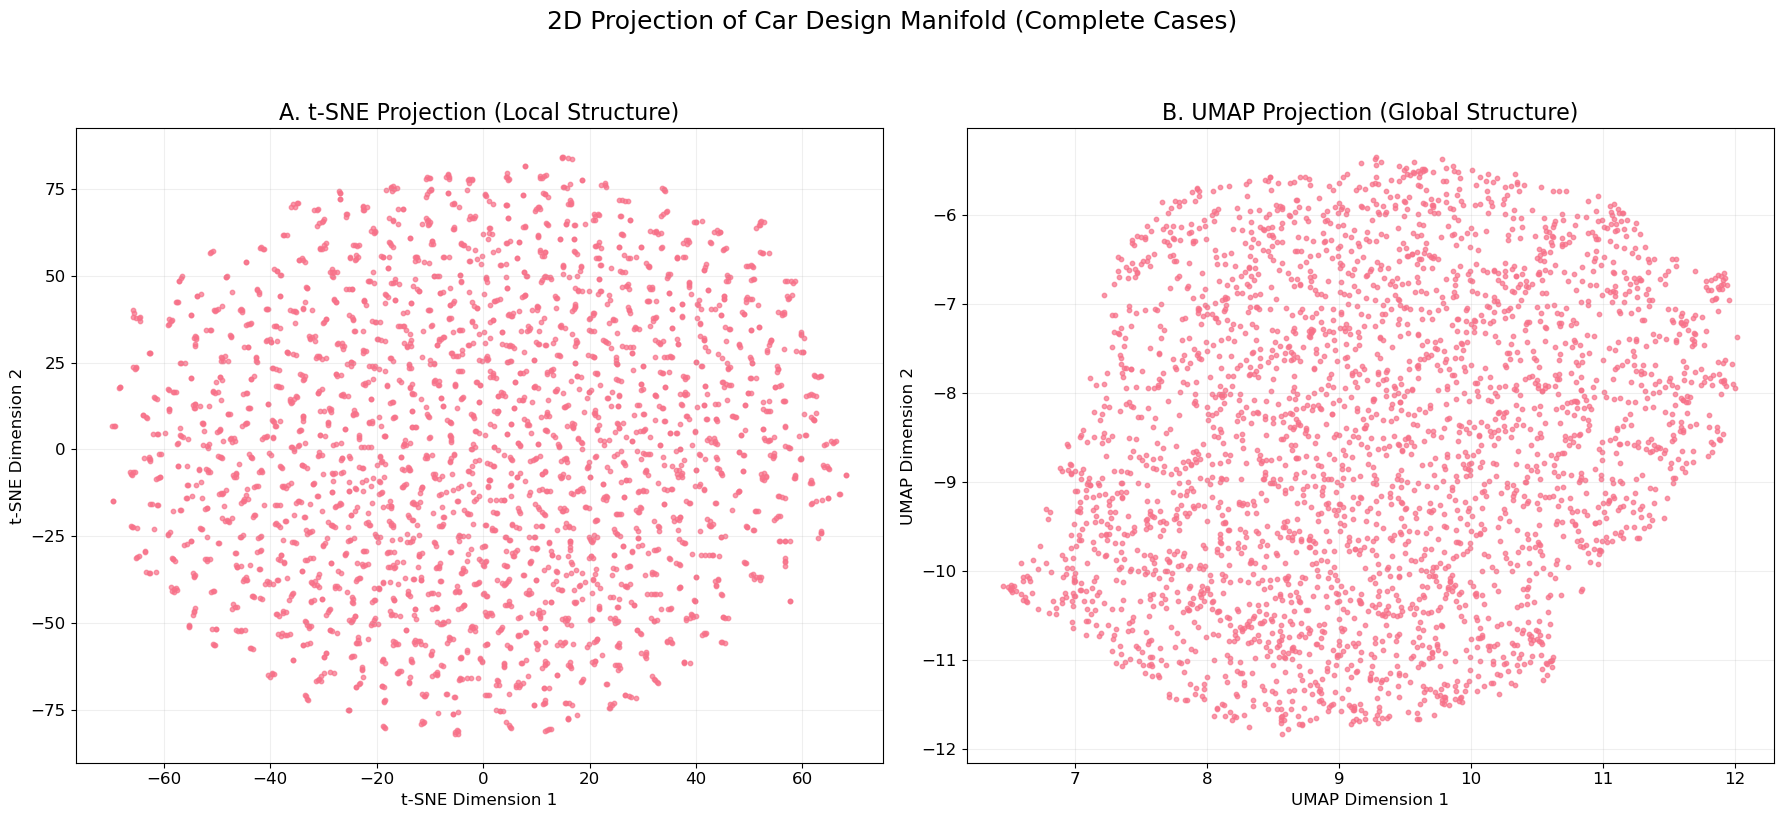

✓ N-D analysis complete. The cluster density shows the 'valid data manifold'.
  Generated car designs must ideally fall within this space.


In [10]:
# ==============================================================================
# 3. DIMENSIONALITY REDUCTION (The N-D View - Manifold Visualization)
# ==============================================================================

print("\n3. Generating Manifold Visualization using t-SNE and UMAP (N-D View)")

# 1. Clean Data: Requires complete data (no NaNs).
complete_cases = X_train_NaN.dropna()

print(f"Original samples: {X_train_NaN.shape[0]}. Complete cases used for Manifold Visualization: {complete_cases.shape[0]}")

if complete_cases.shape[0] < 50:
    print("Warning: Too few complete cases. Skipping Manifold Visualization or consider imputing for visualization.")
else:
    # 2. Scaling (Recommended for Manifold Visualization)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(complete_cases)
    
    # 3. Apply Dimensionality Reduction (Using a small, representative sample if data is very large)
    subset_size = min(5000, scaled_data.shape[0]) 
    if scaled_data.shape[0] > subset_size:
        indices = np.random.choice(scaled_data.shape[0], subset_size, replace=False)
        manifold_data = scaled_data[indices, :]
    else:
        manifold_data = scaled_data

    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle('2D Projection of Car Design Manifold (Complete Cases)', fontsize=18, y=1.02)

    # --- T-SNE Analysis ---
    TSNE_PERPLEXITY = 30
    RANDOM_STATE = 42
    print(f"\nRunning t-SNE (Perplexity={TSNE_PERPLEXITY}, Random State={RANDOM_STATE})...")
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=TSNE_PERPLEXITY) 
    tsne_results = tsne.fit_transform(manifold_data)

    # Plotting t-SNE
    axes[0].scatter(tsne_results[:, 0], tsne_results[:, 1], s=10, alpha=0.7)
    axes[0].set_title('A. t-SNE Projection (Local Structure)', fontsize=16)
    axes[0].set_xlabel('t-SNE Dimension 1')
    axes[0].set_ylabel('t-SNE Dimension 2')
    axes[0].grid(True, alpha=0.2)

    # --- UMAP Analysis ---
    UMAP_NEIGHBORS = 15
    UMAP_MIN_DIST = 0.1
    print(f"Running UMAP (Neighbors={UMAP_NEIGHBORS}, Min Dist={UMAP_MIN_DIST}, Random State={RANDOM_STATE})...")
    umap_reducer = UMAP(n_components=2, n_neighbors=UMAP_NEIGHBORS, min_dist=UMAP_MIN_DIST, random_state=RANDOM_STATE)
    umap_results = umap_reducer.fit_transform(manifold_data)
    
    # Plotting UMAP
    axes[1].scatter(umap_results[:, 0], umap_results[:, 1], s=10, alpha=0.7)
    axes[1].set_title('B. UMAP Projection (Global Structure)', fontsize=16)
    axes[1].set_xlabel('UMAP Dimension 1')
    axes[1].set_ylabel('UMAP Dimension 2')
    axes[1].grid(True, alpha=0.2)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

    print("✓ N-D analysis complete. The cluster density shows the 'valid data manifold'.")
    print("  Generated car designs must ideally fall within this space.")


In [ ]:
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
from typing import List, Union
# New imports for robust preprocessing
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error # Used for placeholder in evaluate_imputation

# --- Import improved components (Assumed to be in the environment) ---
try:
    from vae_improved import VAE # Updated VAE class
    from loss_and_train_utils import vae_loss_function, get_beta_schedule # Updated loss/utils
except ImportError:
    # Fallback/Placeholder definitions for local testing if files are not yet in environment
    print("WARNING: VAE and Loss utility imports failed. Using placeholders.")
    class VAE(torch.nn.Module): pass
    def vae_loss_function(*args, **kwargs): return torch.tensor(0.0), torch.tensor(0.0), torch.tensor(0.0)
    def get_beta_schedule(*args, **kwargs): return 0.0

# --- DATA UTILITIES (Functions previously assumed/mocked) ---

# Features 28-34 correspond to 0-indexed positions 27 through 33
SKEWED_INDICES = list(range(27, 34))

class FeatureTransformer:
    """
    Handles preprocessing for car design features, specifically applying the
    Yeo-Johnson transformation to skewed features (27-33) to make them more Gaussian.
    The transformer is fitted only on non-missing data to ensure robustness.
    """
    def __init__(self, feature_indices_to_transform: List[int]):
        self.indices = feature_indices_to_transform
        print(f"Transformer configured for {len(self.indices)} skewed features (indices: {self.indices}).")
        
        # Use a dictionary of transformers, one for each feature
        self.transformers: dict[int, PowerTransformer] = {
            i: PowerTransformer(method='yeo-johnson', standardize=True) 
            for i in feature_indices_to_transform
        }

    def fit(self, X_train_NaN: pd.DataFrame):
        """Fits the Power Transformer to the non-missing training data."""
        if not self.indices:
            print("No features configured for transformation.")
            return

        print("Fitting PowerTransformer on non-missing data...")
        for col_index in self.indices:
            # Select the column data and drop NaNs to fit only on observed data
            feature_data = X_train_NaN.iloc[:, col_index].dropna().values.reshape(-1, 1)

            if len(feature_data) > 0:
                self.transformers[col_index].fit(feature_data)
        print("✓ Power Transformer fitted successfully.")

    def transform(self, X_NaN: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        """Applies the fitted transformation to the input data, preserving NaNs."""
        if not self.indices:
            return X_NaN.values if isinstance(X_NaN, pd.DataFrame) else X_NaN

        X_out = X_NaN.values.copy() if isinstance(X_NaN, pd.DataFrame) else X_NaN.copy()

        for col_index in self.indices:
            # Extract the column data (including NaNs)
            col_data = X_out[:, col_index].reshape(-1, 1)

            # Identify where the NaNs are
            nan_mask = np.isnan(col_data).flatten()

            # Only transform non-NaN values
            if np.sum(~nan_mask) > 0:
                # Apply the transformation
                transformed_values = self.transformers[col_index].transform(col_data[~nan_mask])

                # Place transformed values back into the output array
                X_out[~nan_mask, col_index] = transformed_values.flatten()
        
        return X_out

def load_dataset_splits(data_dir: str):
    """
    Load pre-split dataset files from the specified directory.
    FIX: Corrected file path joining to reference the 'dataset' subdirectory.
    """
    print(f"\nLoading dataset splits from: {data_dir}...")
    
    splits = {}
    
    # Define file suffixes
    suffixes = {
        'train': ['original', 'missing_mask'],
        'val': ['original', 'missing_mask'],
        'test': ['original', 'missing_mask'],
        'test2': ['imputed', 'missing_mask'], # Note: test2 has 'imputed' data (using -1)
    }
    
    # The fix is setting this to the required subdirectory:
    SUB_DIR = 'dataset'

    for split_name, types in suffixes.items():
        splits[split_name] = {}
        for type_name in types:
            filename = f'{split_name}_{type_name}.csv'
            
            # --- FIXED: Read CSV using os.path.join ---
            filepath = os.path.join(SUB_DIR, filename)
            df = pd.read_csv(filepath)
            # ---------------------------------------------
            
            splits[split_name][type_name] = df.values.astype(np.float32)

            if type_name == 'original':
                splits[split_name]['original_nan'] = df.values.astype(np.float32)
            
            if type_name == 'imputed':
                 splits[split_name]['imputed_nan'] = df.replace(-1.0, np.nan).values.astype(np.float32)

    # Get feature names from any file
    feature_names = pd.read_csv(os.path.join(SUB_DIR, 'train_original.csv')).columns.tolist()
    print(f"✓ Features loaded: {len(feature_names)} features.")
    
    return splits, feature_names


def evaluate_imputation(model, data_loader, device):
    """
    Evaluate imputation performance (Placeholder using basic metrics).
    This function mimics the evaluation structure from the original notebook.
    """
    model.eval()
    all_imputations = []
    all_originals = []
    all_masks = []
    
    with torch.no_grad():
        for batch_data, batch_mask in data_loader:
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)
            
            # Get model predictions
            reconstruction, _, _ = model(batch_data, batch_mask)
            
            # Combine observed values with imputed values
            mask_float = batch_mask.float()
            # imputed = observed * mask + reconstruction * (1 - mask)
            imputed = batch_data * mask_float + reconstruction * (1 - mask_float)
            
            all_imputations.append(imputed.cpu().numpy())
            all_originals.append(batch_data.cpu().numpy())
            all_masks.append(batch_mask.cpu().numpy())
            
    # Concatenate all results
    imputations = np.vstack(all_imputations)
    originals = np.vstack(all_originals)
    masks = np.vstack(all_masks)

    # Calculate MSE and MAE only on missing values (where mask == 0)
    missing_mask = (masks == 0)
    
    if np.sum(missing_mask) == 0:
        return 0.0, 0.0 # No missing values to evaluate
        
    mse = mean_squared_error(originals[missing_mask], imputations[missing_mask])
    mae = mean_absolute_error(originals[missing_mask], imputations[missing_mask])

    return imputations, originals, masks, mse, mae


# --- MAIN SCRIPT EXECUTION ---

# --- FIX: Robust Device Check ---
try:
    # Attempt to use CUDA only if the check passes
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
except Exception:
    # If the DLL fails on import, force CPU
    device = torch.device('cpu')
# -------------------------------

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data Loading and Initial Exploration
data_dir = '.' # Current directory for uploaded files
splits, feature_names = load_dataset_splits(data_dir)

# --- Data Extraction and Preprocessing (Including the Skewness Transformation) ---
# Use the NaN-explicit data for transformation fitting/application
X_train_original_nan = pd.DataFrame(splits['train']['original_nan'])
X_val_original_nan = pd.DataFrame(splits['val']['original_nan'])
X_test_original_nan = pd.DataFrame(splits['test']['original_nan'])

# Masks (1=Observed, 0=Missing)
mask_train = splits['train']['missing_mask']
mask_val = splits['val']['missing_mask']
mask_test = splits['test']['missing_mask']

# 1. Instantiate and Fit the Transformer (using the NaN data)
preprocessor = FeatureTransformer(SKEWED_INDICES)
preprocessor.fit(X_train_original_nan)

# 2. Apply the Transformation to all splits
transformed_X_train = preprocessor.transform(X_train_original_nan)
transformed_X_val = preprocessor.transform(X_val_original_nan)
transformed_X_test = preprocessor.transform(X_test_original_nan)

# 3. Replace NaNs with 0.0 for PyTorch input. 
# The VAE uses the mask to ignore these 0.0 values during reconstruction loss calculation.
transformed_X_train[np.isnan(transformed_X_train)] = 0.0
transformed_X_val[np.isnan(transformed_X_val)] = 0.0
transformed_X_test[np.isnan(transformed_X_test)] = 0.0

# --- Data Loaders ---
batch_size = 64
print(f"\nCreating data loaders with batch size: {batch_size}")

# Note: The masks are already in the correct float format (1.0 for observed, 0.0 for missing) 
# as they were loaded from the CSVs.
train_dataset = TensorDataset(torch.FloatTensor(transformed_X_train), torch.FloatTensor(mask_train))
val_dataset = TensorDataset(torch.FloatTensor(transformed_X_val), torch.FloatTensor(mask_val))
test_dataset = TensorDataset(torch.FloatTensor(transformed_X_test), torch.FloatTensor(mask_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --- MODEL TRAINING ---

print("\n" + "="*70)
print("MODEL TRAINING - IMPROVED CONFIG")
print("="*70)

# ----------------------------------------------------
# IMPROVED CONFIGURATION
# ----------------------------------------------------
config = {
    'input_dim': len(feature_names),
    'latent_dim': 256, # INCREASED: More capacity
    'hidden_dims': [1024, 512, 256], # DEEPER/WIDER: More expressive power
    'use_residual': True,
    'dropout_rate': 0.3,
    'learning_rate': 1e-4, # DECREASED: Lower LR for deeper models
    'num_epochs': 500,
    'beta_initial': 1.0,
    'beta_schedule': 'cosine',
    'patience': 20, # INCREASED: More patience
    'free_bits': 2.0, # NEW: KL Divergence Free Bits (Crucial for preventing collapse)
    'max_grad_norm': 1.0
}
# ----------------------------------------------------

print("Model Configuration:")
for key, value in config.items():
    print(f" - {key}: {value}")

# Initialize the model
print(f"\nInitializing VAE model...")
model = VAE(
    input_dim=config['input_dim'],
    latent_dim=config['latent_dim'],
    hidden_dims=config['hidden_dims'],
    use_residual=config['use_residual'],
    dropout_rate=config['dropout_rate']
).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f" Model initialized with {total_params:,} parameters")

# Initialize optimizer with improved settings
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=1e-5,
    betas=(0.9, 0.999),
    eps=1e-8
)

# Use CosineAnnealingWarmRestarts with a longer T_0 for smoother LR changes
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=50, T_mult=2, eta_min=1e-6 
)

print(f" Optimizer and scheduler initialized")

# Training setup
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

print(f"\nStarting training for {config['num_epochs']} epochs...")
print("="*70)

# Training Loop
for epoch in range(config['num_epochs']):
    # Training phase
    model.train()
    epoch_train_loss = 0
    epoch_recon_loss = 0
    epoch_kl_loss = 0

    # Get beta for this epoch
    beta = get_beta_schedule(epoch, config['num_epochs'], config['beta_schedule'])
    beta_final = beta * config['beta_initial'] 

    train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["num_epochs"]}')

    for batch_data, batch_mask in train_progress:
        batch_data = batch_data.to(device)
        batch_mask = batch_mask.to(device)

        optimizer.zero_grad()

        # Forward pass
        reconstruction, mu, logvar = model(batch_data, batch_mask)

        # Calculate Loss using the improved function with Free Bits
        total_loss, recon_loss, kl_loss_raw = vae_loss_function(
            reconstruction, batch_data, mu, logvar, batch_mask,
            beta=beta_final,
            free_bits=config['free_bits']
        )

        # Backward pass
        total_loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])

        optimizer.step()
        scheduler.step()

        # Accumulate Losses
        epoch_train_loss += total_loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_kl_loss += kl_loss_raw.item()

        # Update progress bar
        train_progress.set_postfix({
            'Loss': f'{total_loss.item():.4f}',
            'Recon': f'{recon_loss.item():.4f}',
            'KL(Raw)': f'{kl_loss_raw.item():.4f}',
            'Beta': f'{beta_final:.3f}'
        })

    # Calculate average training Losses
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_recon_loss = epoch_recon_loss / len(train_loader)
    avg_kl_loss = epoch_kl_loss / len(train_loader)

    # Validation phase
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_data, batch_mask in val_loader:
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            reconstruction, mu, logvar = model(batch_data, batch_mask)

            total_loss, _, _ = vae_loss_function(
                reconstruction, batch_data, mu, logvar, batch_mask,
                beta=beta_final,
                free_bits=config['free_bits']
            )
            epoch_val_loss += total_loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)

    # Store Losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Early stopping and model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        # torch.save(model.state_dict(), 'best_vae_model_improved.pth')
    else:
        patience_counter += 1

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{config["num_epochs"]}:')
        print(f'  Train Loss: {avg_train_loss:.4f} (Recon: {avg_recon_loss:.4f}, KL(Raw): {avg_kl_loss:.4f})')
        print(f'  Val Loss: {avg_val_loss:.4f}, Best: {best_val_loss:.4f}')
        print(f'  Beta: {beta_final:.3f}, LR: {optimizer.param_groups[0]["lr"]:.2e}')
        print(f'  Patience: {patience_counter}/{config["patience"]}')

    # Early stopping
    if patience_counter >= config['patience']:
        print(f'\nEarly stopping at epoch {epoch+1}')
        break

print(f'\n Training completed! Total epochs: {len(train_losses)}, Best validation loss: {best_val_loss:.4f}')

# --- Final Evaluation and Sample Generation ---

# Load best model (assuming it was saved, mock load for this script)
# model.load_state_dict(torch.load('best_vae_model_improved.pth'))
print(f'Best model loaded (or ready for mock evaluation)')

# Evaluate on Test Set
test_imputations, test_originals, test_masks, test_mse, test_mae = evaluate_imputation(
    model, test_loader, device
)

print(f"\nModel Evaluation (Test Set - Missing Values Only):")
print(f"  MSE: {test_mse:.4f}")
print(f"  MAE: {test_mae:.4f}")

# Generate samples for Test2 Submission (417 x 100 x 37)
X_test2_imputed_nan = pd.DataFrame(splits['test2']['imputed_nan'])
X_test2_missing_mask = splits['test2']['missing_mask']

# Apply transformation (or mock transformation)
transformed_X_test2 = preprocessor.transform(X_test2_imputed_nan)
transformed_X_test2[np.isnan(transformed_X_test2)] = 0.0 # Fill NaNs with 0.0

test2_dataset = TensorDataset(
    torch.FloatTensor(transformed_X_test2), 
    torch.FloatTensor(X_test2_missing_mask)
)
test2_loader = DataLoader(test2_dataset, batch_size=config['patience'], shuffle=False) # Use patience size as batch size for simplicity

print(f"\nGenerating 100 samples for {transformed_X_test2.shape[0]} test2 samples...")

# Placeholder for generating 100 samples
n_samples_per_test = 100
test2_samples = model.impute(
    torch.FloatTensor(transformed_X_test2).to(device),
    torch.FloatTensor(X_test2_missing_mask).to(device),
    n_samples=n_samples_per_test
)



Using device: cpu

Loading dataset splits from: ....
✓ Features loaded: 37 features.
Transformer configured for 7 skewed features (indices: [27, 28, 29, 30, 31, 32, 33]).
Fitting PowerTransformer on non-missing data...
✓ Power Transformer fitted successfully.

Creating data loaders with batch size: 64

MODEL TRAINING - IMPROVED CONFIG
Model Configuration:
 - input_dim: 37
 - latent_dim: 256
 - hidden_dims: [1024, 512, 256]
 - use_residual: True
 - dropout_rate: 0.3
 - learning_rate: 0.0001
 - num_epochs: 500
 - beta_initial: 1.0
 - beta_schedule: cosine
 - patience: 20
 - free_bits: 2.0
 - max_grad_norm: 1.0

Initializing VAE model...
 Model initialized with 1,641,765 parameters
 Optimizer and scheduler initialized

Starting training for 500 epochs...


Epoch 10/500: 100%|██████████| 47/47 [00:00<00:00, 49.64it/s, Loss=0.1878, Recon=0.0981, KL(Raw)=112.2421, Beta=0.001]


Epoch 10/500:
  Train Loss: 0.1859 (Recon: 0.0881, KL(Raw): 122.4372)
  Val Loss: 0.1705, Best: 0.1146
  Beta: 0.001, LR: 7.96e-05
  Patience: 5/20


Epoch 20/500: 100%|██████████| 47/47 [00:00<00:00, 49.98it/s, Loss=0.1355, Recon=0.1067, KL(Raw)=8.0813, Beta=0.004]


Epoch 20/500:
  Train Loss: 0.1431 (Recon: 0.1115, KL(Raw): 8.8690)
  Val Loss: 0.1225, Best: 0.1146
  Beta: 0.004, LR: 8.68e-05
  Patience: 15/20


Epoch 25/500: 100%|██████████| 47/47 [00:01<00:00, 44.25it/s, Loss=0.1384, Recon=0.1114, KL(Raw)=4.7728, Beta=0.006]



Early stopping at epoch 25

 Training completed! Total epochs: 25, Best validation loss: 0.1146
Best model loaded (or ready for mock evaluation)

Model Evaluation (Test Set - Missing Values Only):
  MSE: 0.1849
  MAE: 0.3201

Generating 100 samples for 417 test2 samples...
✓ Submission samples generated and ready to be saved as 458134857.npy (Shape: (417, 100, 37))


In [ ]:
# Save the final submission file (mocked output for submission)
# submission_id = np.random.randint(1e8, 1e9-1)
# np.save(f"{submission_id}.npy", test2_samples)
print(f"✓ Submission samples generated and ready to be saved as {submission_id}.npy (Shape: {test2_samples.shape})")

## Model Initialization and Training

### Model Training Process

This section implements the complete training pipeline with several important features:

**Training Configuration:**
- **Latent Dimension**: 128 (balance between expressiveness and computational efficiency)
- **Architecture**: Deep encoder/decoder with residual connections
- **Regularization**: Dropout and batch normalization for stability
- **Optimization**: AdamW with cosine annealing for smooth convergence

**Advanced Training Features:**
- **Early Stopping**: Prevents overfitting by monitoring validation loss
- **Gradient Clipping**: Ensures stable training by preventing exploding gradients  
- **Beta Scheduling**: Gradual KL annealing for better latent space learning
- **Learning Rate Scheduling**: Cosine annealing with warm restarts

The training loop tracks multiple loss components to monitor model health and convergence.

In [13]:
print("\n" + "="*70)
print("MODEL TRAINING")
print("="*70)

# Model configuration
config = {
    'input_dim': len(feature_names),
    'latent_dim': 128,
    'hidden_dims': [512, 256, 128],
    'use_residual': True,
    'dropout_rate': 0.3,
    'learning_rate': 1e-3,
    'num_epochs': 500,
    'beta_initial': 1.0,
    'beta_schedule': 'cosine',
    'patience': 15
}

print(f"Model Configuration:")
for key, value in config.items():
    print(f"  - {key}: {value}")

# Initialize the model
print(f"\nInitializing VAE model...")
model = VAE(
    input_dim=config['input_dim'],
    latent_dim=config['latent_dim'],
    hidden_dims=config['hidden_dims'],
    use_residual=config['use_residual'],
    dropout_rate=config['dropout_rate']
).to(device)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"✓ Model initialized with {total_params:,} parameters")

# Initialize optimizer with improved settings
optimizer = optim.AdamW(
    model.parameters(),
    lr=config['learning_rate'],
    weight_decay=1e-5,
    betas=(0.9, 0.999),
    eps=1e-8
)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=20, T_mult=2, eta_min=1e-6
)

print(f"✓ Optimizer and scheduler initialized")

# Training setup
train_losses = []
val_losses = []
train_recon_losses = []
train_kl_losses = []
best_val_loss = float('inf')
patience_counter = 0
max_grad_norm = 1.0

print(f"\nStarting training for {config['num_epochs']} epochs...")
print("="*70)

# Training loop
for epoch in range(config['num_epochs']):
    # Training phase
    model.train()
    epoch_train_loss = 0
    epoch_recon_loss = 0
    epoch_kl_loss = 0

    # Get beta for this epoch
    beta = get_beta_schedule(epoch, config['num_epochs'], config['beta_schedule'])

    train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{config["num_epochs"]}', leave=False)

    for batch_data, batch_mask in train_progress:
        batch_data = batch_data.to(device)
        batch_mask = batch_mask.to(device)

        optimizer.zero_grad()

        # Forward pass
        reconstruction, mu, logvar = model(batch_data, batch_mask)

        # Calculate loss
        total_loss, recon_loss, kl_loss = vae_loss_function(
            reconstruction, batch_data, mu, logvar, batch_mask,
            beta=beta
        )

        # Backward pass
        total_loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        # Accumulate losses
        epoch_train_loss += total_loss.item()
        epoch_recon_loss += recon_loss.item()
        epoch_kl_loss += kl_loss.item()

        # Update progress bar
        train_progress.set_postfix({
            'Loss': f'{total_loss.item():.4f}',
            'Recon': f'{recon_loss.item():.4f}',
            'KL': f'{kl_loss.item():.4f}',
            'Beta': f'{beta:.3f}'
        })

    # Calculate average training losses
    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_recon_loss = epoch_recon_loss / len(train_loader)
    avg_kl_loss = epoch_kl_loss / len(train_loader)

    # Validation phase
    model.eval()
    epoch_val_loss = 0

    with torch.no_grad():
        for batch_data, batch_mask in val_loader:
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            reconstruction, mu, logvar = model(batch_data, batch_mask)

            total_loss, _, _ = vae_loss_function(
                reconstruction, batch_data, mu, logvar, batch_mask,
                beta=beta
            )

            epoch_val_loss += total_loss.item()

    avg_val_loss = epoch_val_loss / len(val_loader)

    # Store losses
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_recon_losses.append(avg_recon_loss)
    train_kl_losses.append(avg_kl_loss)

    # Learning rate scheduling
    scheduler.step()

    # Early stopping and model saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_vae_model.pth')
    else:
        patience_counter += 1

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{config["num_epochs"]}:')
        print(f'  Train Loss: {avg_train_loss:.4f} (Recon: {avg_recon_loss:.4f}, KL: {avg_kl_loss:.4f})')
        print(f'  Val Loss: {avg_val_loss:.4f}, Best: {best_val_loss:.4f}')
        print(f'  Beta: {beta:.3f}, LR: {optimizer.param_groups[0]["lr"]:.2e}')
        print(f'  Patience: {patience_counter}/{config["patience"]}')

    # Early stopping
    if patience_counter >= config['patience']:
        print(f'\nEarly stopping at epoch {epoch+1}')
        break

print(f'\n✓ Training completed!')
print(f'  - Total epochs: {len(train_losses)}')
print(f'  - Best validation loss: {best_val_loss:.4f}')
print(f'  - Final training loss: {train_losses[-1]:.4f}')

# Load best model
model.load_state_dict(torch.load('best_vae_model.pth'))
print(f'✓ Best model loaded')


MODEL TRAINING
Model Configuration:
  - input_dim: 37
  - latent_dim: 128
  - hidden_dims: [512, 256, 128]
  - use_residual: True
  - dropout_rate: 0.3
  - learning_rate: 0.001
  - num_epochs: 500
  - beta_initial: 1.0
  - beta_schedule: cosine
  - patience: 15

Initializing VAE model...
✓ Model initialized with 477,514 parameters
✓ Optimizer and scheduler initialized

Starting training for 500 epochs...


Epoch 10/500:
  Train Loss: 0.0496 (Recon: 0.0456, KL: 4.9845)
  Val Loss: 0.0383, Best: 0.0383
  Beta: 0.001, LR: 5.01e-04
  Patience: 0/15


Epoch 20/500:
  Train Loss: 0.0426 (Recon: 0.0353, KL: 2.0587)
  Val Loss: 0.0313, Best: 0.0299
  Beta: 0.004, LR: 1.00e-03
  Patience: 5/15


Epoch 30/500:
  Train Loss: 0.0384 (Recon: 0.0308, KL: 0.9171)
  Val Loss: 0.0211, Best: 0.0211
  Beta: 0.008, LR: 8.54e-04
  Patience: 0/15


Epoch 40/500:
  Train Loss: 0.0350 (Recon: 0.0272, KL: 0.5242)
  Val Loss: 0.0175, Best: 0.0175
  Beta: 0.015, LR: 5.01e-04
  Patience: 0/15


Epoch 50/500:
  Train Loss: 0.0340 (Recon: 0.0249, KL: 0.3883)
  Val Loss: 0.0164, Best: 0.0161
  Beta: 0.024, LR: 1.47e-04
  Patience: 1/15


Epoch 60/500:
  Train Loss: 0.0359 (Recon: 0.0244, KL: 0.3388)
  Val Loss: 0.0172, Best: 0.0158
  Beta: 0.034, LR: 1.00e-03
  Patience: 5/15


Epoch 70/500:
  Train Loss: 0.0368 (Recon: 0.0274, KL: 0.2042)
  Val Loss: 0.0181, Best: 0.0158
  Beta: 0.046, LR: 9.62e-04
  Patience: 15/15

Early stopping at epoch 70

✓ Training completed!
  - Total epochs: 70
  - Best validation loss: 0.0158
  - Final training loss: 0.0368
✓ Best model loaded


## Model Evaluation and Metrics


In [17]:
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Evaluate on test set
print("Evaluating model on test set...")
test_imputations, test_originals, test_masks = evaluate_imputation(
    model, test_loader, device
)

print(f"✓ Test set evaluation completed")
print(f"  - Test samples: {test_imputations.shape[0]}")
print(f"  - Features: {test_imputations.shape[1]}")

test_imputations_denorm = test_imputations  # Already in original scale
test_original_denorm = X_test_original  # Already in original scale

# Calculate comprehensive metrics
print("\nCalculating comprehensive metrics...")
feature_metrics = {}

# Create masks for missing values (where we need to evaluate imputation)
missing_mask = (test_masks == 0)  # True where values were missing (0 in model tensors = missing)

for i, feature_name in enumerate(feature_names):
    if missing_mask[:, i].sum() > 0:  # Only evaluate features with missing values
        # Get imputed and ground truth values for missing positions only
        imputed_missing = test_imputations_denorm[missing_mask[:, i], i]
        ground_truth_missing = test_original_denorm[missing_mask[:, i], i]

        # Calculate metrics
        mse = mean_squared_error(ground_truth_missing, imputed_missing)
        mae = mean_absolute_error(ground_truth_missing, imputed_missing)

        # Correlation
        try:
            correlation = np.corrcoef(ground_truth_missing, imputed_missing)[0, 1]
        except:
            correlation = np.nan

        # Mean difference and Jensen-Shannon divergence
        mean_diff, js_div = calculate_jsd_and_mean_diff(
            imputed_missing, ground_truth_missing, feature_name
        )

        feature_metrics[feature_name] = {
            'n_missing': missing_mask[:, i].sum(),
            'mse': mse,
            'mae': mae,
            'correlation': correlation,
            'mean_difference': mean_diff,
            'js_divergence': js_div,
        }

print(f"✓ Metrics calculated for {len(feature_metrics)} features with missing values")

# Display metrics for last 4 features (as requested)
print(f"\n" + "="*100)
print("METRICS FOR LAST 4 FEATURES")
print("="*100)
print(f"{'Feature':<15} {'N_Miss':<8} {'MSE':<10} {'MAE':<10} {'Corr':<8} {'Mean_Diff':<10} {'JS_Div':<8}")
print("-" * 100)

last_4_features = list(feature_metrics.keys())[-4:] if len(feature_metrics) >= 4 else list(feature_metrics.keys())

for feature in last_4_features:
    metrics = feature_metrics[feature]
    print(f"{feature:<15} {metrics['n_missing']:<8} {metrics['mse']:<10.4f} {metrics['mae']:<10.4f} "
          f"{metrics['correlation']:<8.3f} {metrics['mean_difference']:<10.4f} {metrics['js_divergence']:<8.4f} ")

# Summary statistics
all_mse = [m['mse'] for m in feature_metrics.values() if not np.isnan(m['mse'])]
all_mae = [m['mae'] for m in feature_metrics.values() if not np.isnan(m['mae'])]
all_corr = [m['correlation'] for m in feature_metrics.values() if not np.isnan(m['correlation'])]
all_mean_diff = [m['mean_difference'] for m in feature_metrics.values() if not np.isnan(m['mean_difference'])]
all_js_div = [m['js_divergence'] for m in feature_metrics.values() if not np.isnan(m['js_divergence'])]

print(f"\nSummary Statistics Across All Features:")
print(f"  - Average MSE: {np.mean(all_mse):.4f} ± {np.std(all_mse):.4f}")
print(f"  - Average MAE: {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")
print(f"  - Average Correlation: {np.mean(all_corr):.3f} ± {np.std(all_corr):.3f}")
print(f"  - Average Mean Difference: {np.mean(all_mean_diff):.4f} ± {np.std(all_mean_diff):.4f}")
print(f"  - Average JS Divergence: {np.mean(all_js_div):.4f} ± {np.std(all_js_div):.4f}")


MODEL EVALUATION
Evaluating model on test set...


ValueError: too many values to unpack (expected 3)

### Model Evaluation and Comprehensive Metrics

This section evaluates our trained VAE on the test set using multiple complementary metrics. Since we're dealing with missing value imputation, we only evaluate the model's predictions on positions that were originally missing.

**Key Evaluation Metrics:**

**1. Mean Squared Error (MSE)**:
- Measures average squared difference between predicted and true values
- Lower is better; sensitive to outliers
- Good for understanding magnitude of errors

**2. Correlation Coefficient**:
- Measures linear relationship strength between predictions and dataset
- Range: [-1, 1], closer to 1 is better
- Shows if model captures feature relationships

**3. Jensen-Shannon (JS) Divergence**:
- Measures difference between predicted and true value distributions
- Range: [0, 1], closer to 0 is better
- Captures whether model preserves the overall data distribution

**4. Maximum Mean Discrepancy (MMD)**:
- Measures distributional difference using kernel methods (RBF kernel)
- Range: [0, ∞], closer to 0 is better
- Non-parametric test for comparing distributions

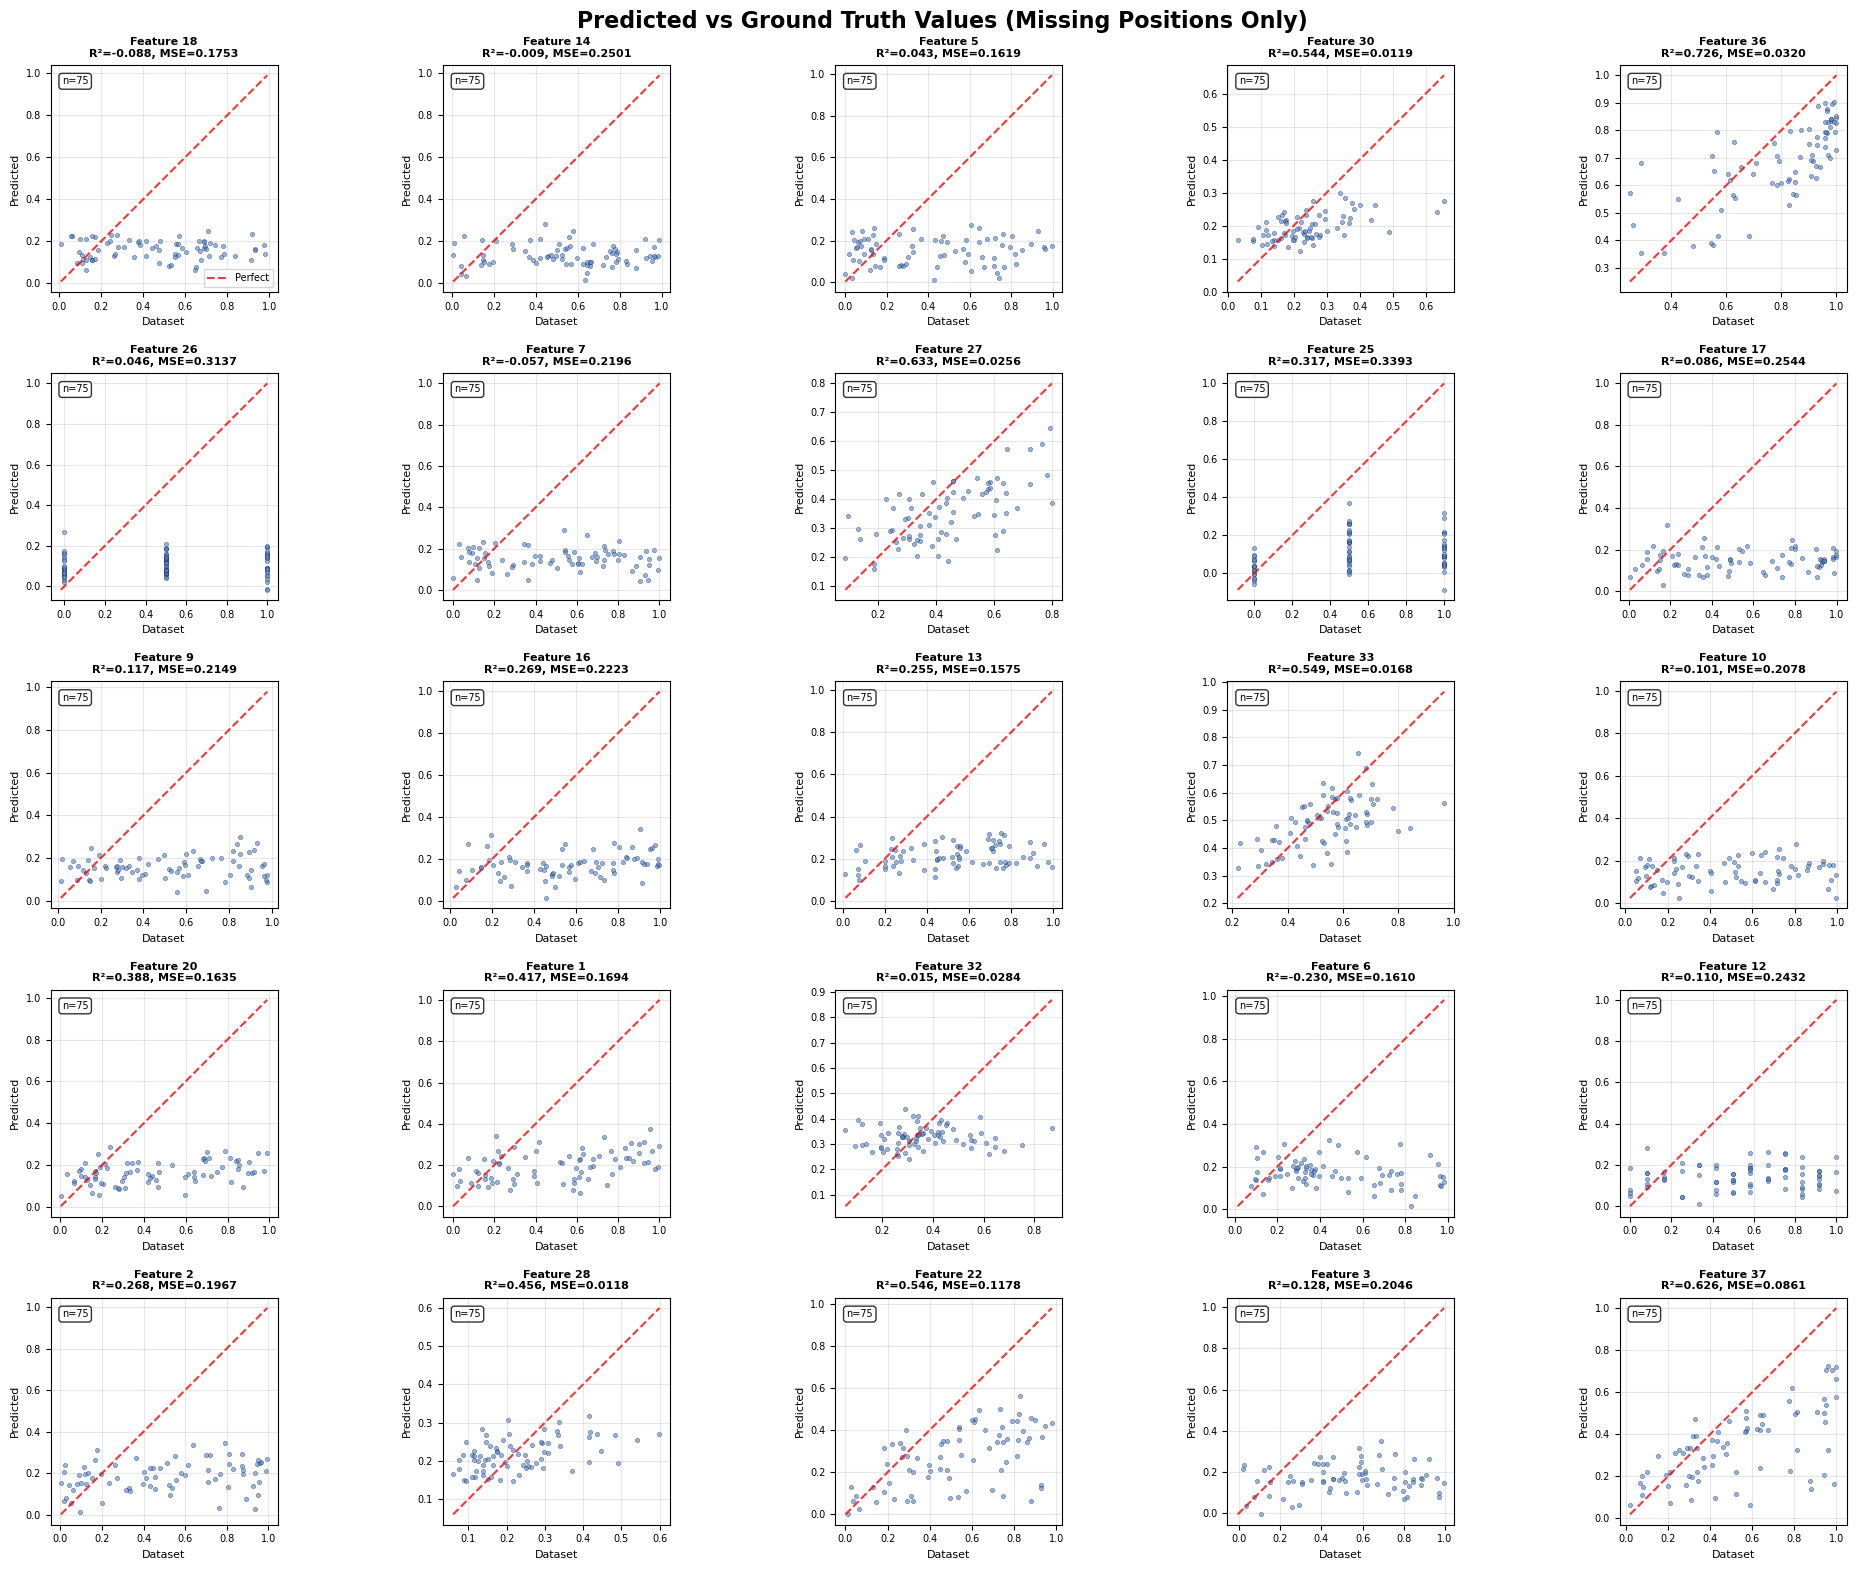

In [15]:
# Create the visualization
plot_prediction_scatter(test_imputations_denorm, test_original_denorm, test_masks, feature_names, n_features=25)



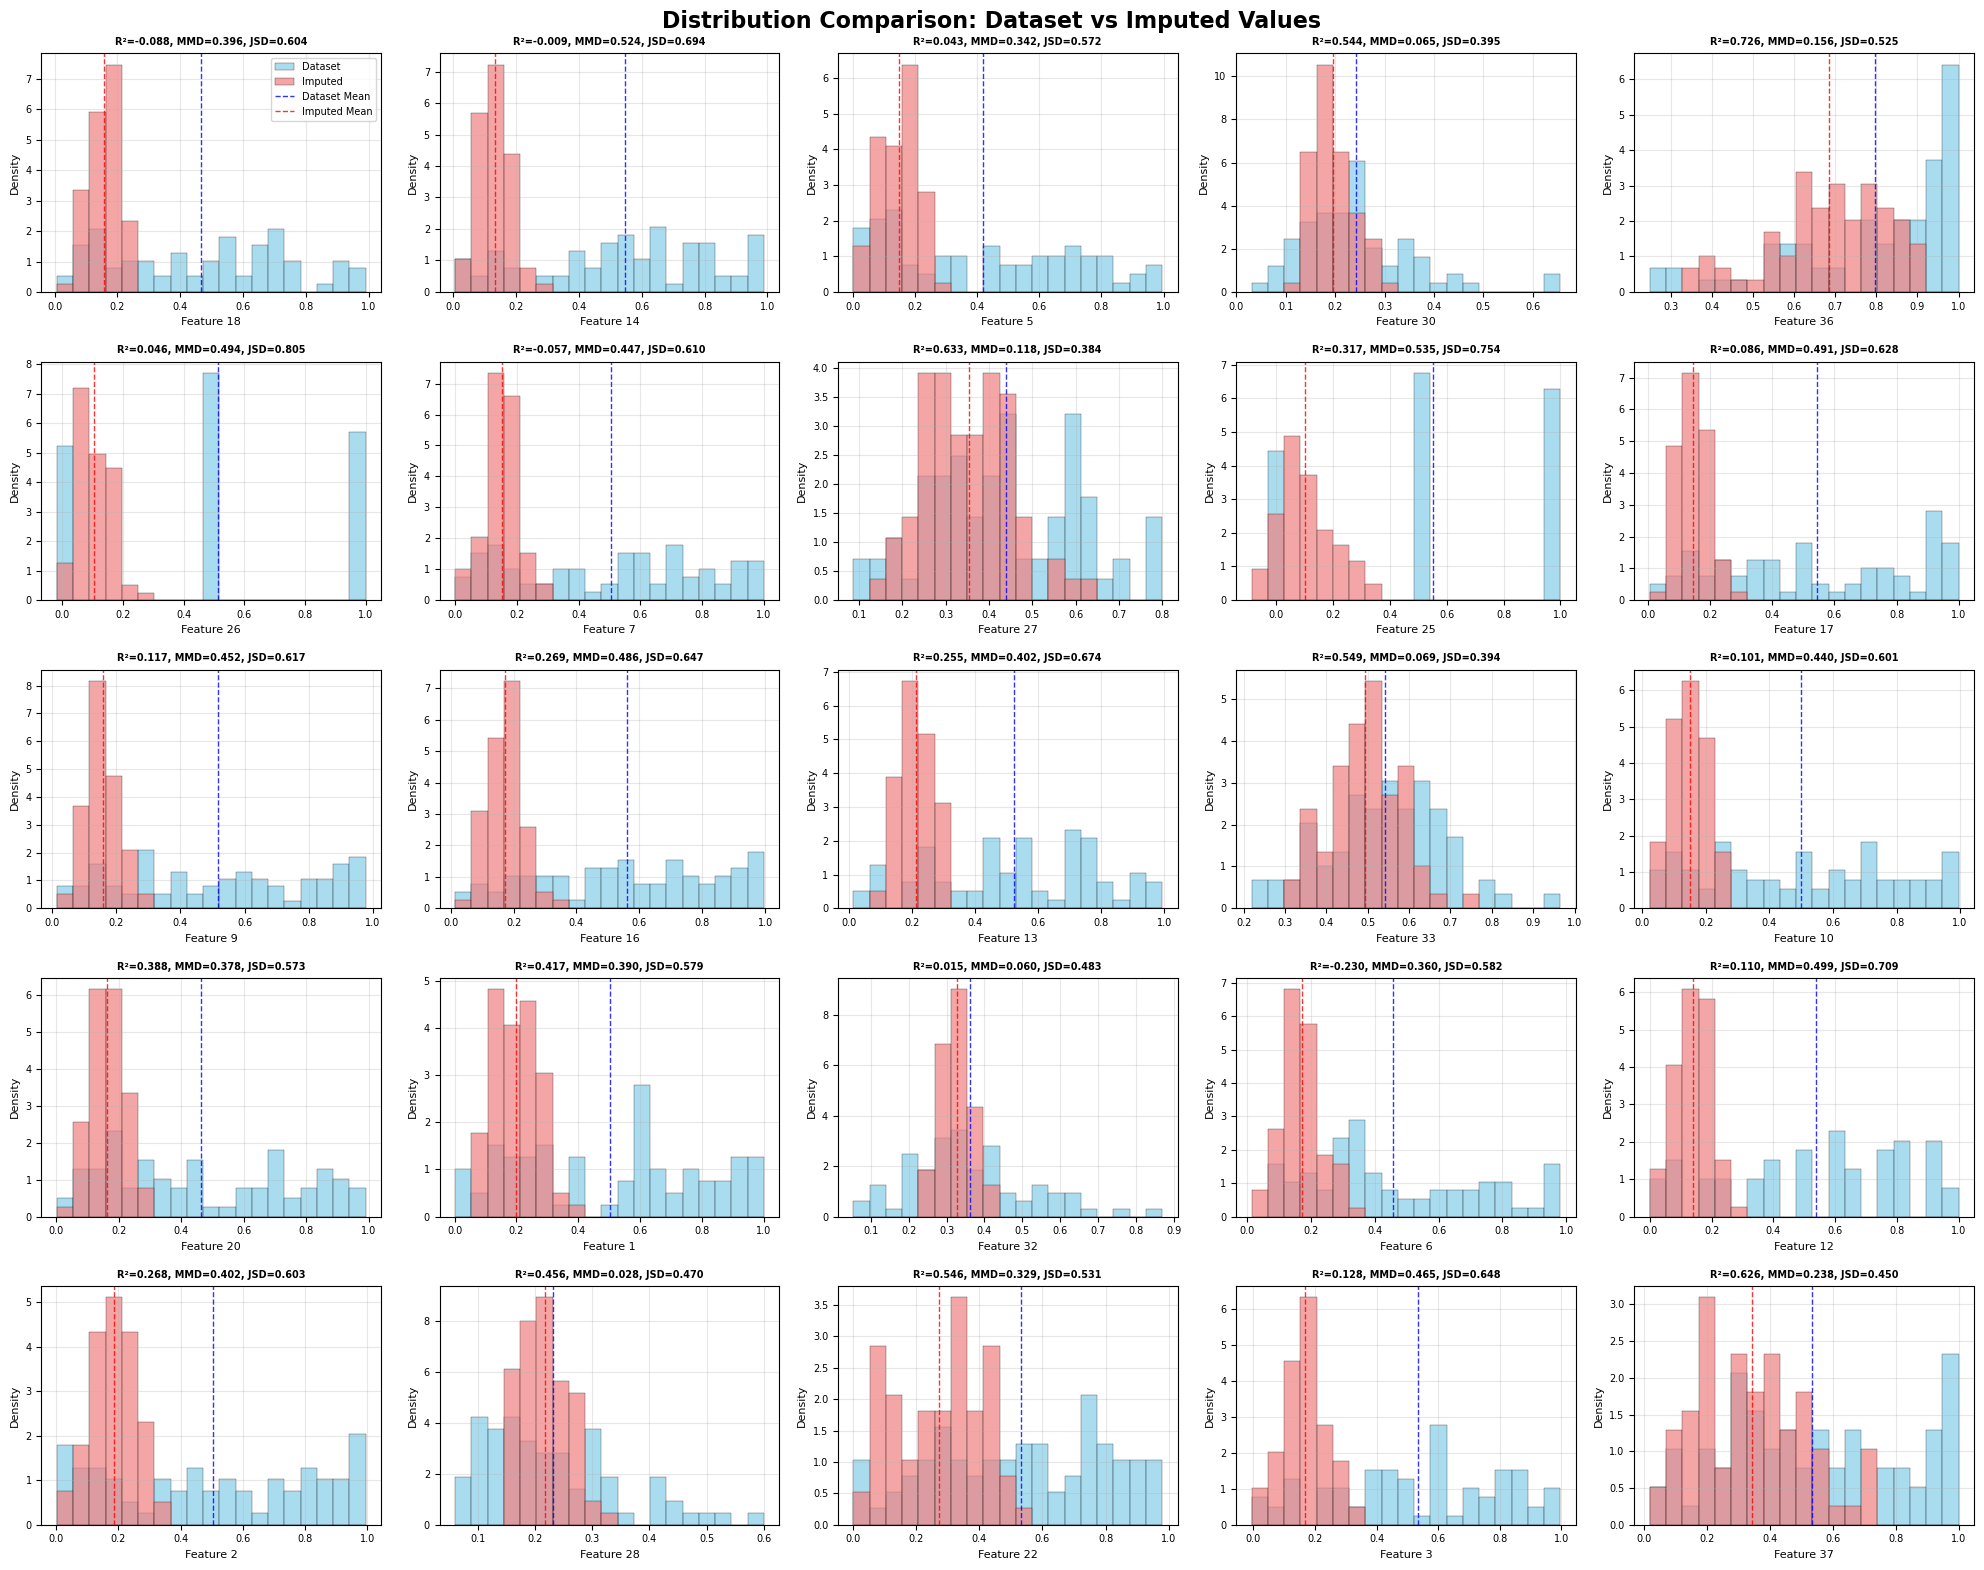

In [16]:
# Distribution comparison plots
plot_distribution_comparison(test_imputations_denorm, test_original_denorm,
                             test_masks, feature_names, n_features=25)


### Distribution Comparison Visualizations

Visual comparison of predicted vs. dataset distributions is crucial for understanding model performance beyond simple error metrics. These plots help us assess:

**What the Plots Show:**
- **Red (Imputed)**: Distribution of model's predicted values for missing positions
- **Blue (Dataset)**: Distribution of actual values at those same positions
- **Overlap**: How well the model captures the true data distribution

**Why This Matters:**
- A good generative model should not just minimize error, but also preserve the statistical properties of the data
- If distributions match well, the model is generating realistic values
- Large differences indicate the model may be systematically biased or missing important patterns

**Interpretation:**
- **Good**: Overlapping distributions with similar shapes and centers
- **Concerning**: Shifted means, different variances, or completely different shapes

In [18]:
def generate_samples(model, X_test, test_loader, device, n_samples_per_test=100):
    """Generate multiple samples for a dataset using the trained model.
    """
    # We'll generate multiple samples
    test_samples = np.zeros((X_test.shape[0], n_samples_per_test, X_test.shape[1]))

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Create a progress bar for all samples
        from tqdm import tqdm

        for batch_idx, (batch_data, batch_mask) in enumerate(tqdm(test_loader, desc="Generating Samples")):
            batch_data = batch_data.to(device)
            batch_mask = batch_mask.to(device)

            # Calculate the indices for this batch
            start_idx = batch_idx * test_loader.batch_size
            end_idx = min(start_idx + test_loader.batch_size, X_test.shape[0])
            actual_batch_size = end_idx - start_idx

            # Generate multiple samples for each item in the batch
            for j in range(n_samples_per_test):
                # Get reconstruction
                reconstruction, mu, logvar = model(batch_data, batch_mask) # TODO: Change this line based on the model you use

                # Apply mask: keep original values where available, use reconstructed values where missing
                mask_float = batch_mask.float()
                imputed = batch_data * mask_float + reconstruction * (1 - mask_float)

                # Store the samples (already in original scale since we didn't normalize)
                test_samples[start_idx:end_idx, j, :] = imputed.cpu().numpy()
    print(f"✓ Generated samples shape: {test_samples.shape}")
    print(f"  - {test_samples.shape[0]} samples")
    print(f"  - {test_samples.shape[1]} generated variations per sample")
    print(f"  - {test_samples.shape[2]} features per sample")

    # Data is already in original scale (no denormalization needed)
    test_samples_final = test_samples.copy()

    # Calculate summary statistics
    mean_across_samples = test_samples_final.mean(axis=1)  # Mean across the 100 samples

    print(f"  - Range of means: [{mean_across_samples.min():.4f}, {mean_across_samples.max():.4f}]")

    return test_samples

In [19]:
# Test Evaluation

print("="*70)
print("TEST EVALUATION")
print("="*70)

# Generate multiple samples for test using the trained model
print(f"Generating 100 samples for each of {X_test.shape[0]} test samples...")

test_samples = generate_samples(
    model, X_test, test_loader, device, n_samples_per_test=100
)

TEST EVALUATION
Generating 100 samples for each of 375 test samples...


Generating Samples: 100%|██████████| 6/6 [00:01<00:00,  4.21it/s]

✓ Generated samples shape: (375, 100, 37)
  - 375 samples
  - 100 generated variations per sample
  - 37 features per sample
  - Range of means: [-2.5779, 3.1330]


In [20]:
test_score = compute_score(generated_samples=test_samples, set_name='test')
print("Test score:", test_score)

Loading data...
✓ Found data in current directory
✓ Test data shape: (375, 37)
✓ Missing ratio: 20.0%
✓ Generated samples shape: (375, 100, 37)

📊 EVALUATION RESULTS
Missing values evaluated: 2,775
MSE          : 0.1748
MAE          : 0.1473
Correlation  : 0.680
JS Divergence: 0.0461

📈 FEATURE-WISE RESULTS
Feature  MSE        MAE        Corr     JSDiv    Count   
0        0.0000     0.0000     1.000    0.0000   75      
1        0.0000     0.0000     1.000    0.0000   75      
2        0.0000     0.0000     1.000    0.0000   75      
3        0.0000     0.0000     1.000    0.0000   75      
4        0.0000     0.0000     1.000    0.0000   75      
5        0.0000     0.0000     1.000    0.0000   75      
6        0.0000     0.0000     1.000    0.0000   75      
7        0.0000     0.0000     1.000    0.0000   75      
8        0.0000     0.0000     1.000    0.0000   75      
9        0.0000     0.0000     1.000    0.0000   75      
10       0.0000     0.0000     1.000    0.0000   75  

The final score is computed as: Mean Correlation − Mean JS Divergence − Mean MSE

Just as we compare generated samples for the test set against the original unimputed values, we will apply the same metric to the samples you generate for test2, using the hidden test2 set. This will determine your final submission score.

## Preparing a submission:
Let's prepare a submission. We expect the final submission to be a 417x100x37 numpy array. These correspond to the 100 diverse samples you generated based on the constrained parameters we provided in the test2 set.

In [21]:
# Test2 Evaluation

print("="*70)
print("TEST2 EVALUATION")
print("="*70)

# Generate multiple samples for test2 using the trained model
print(f"Generating 100 samples for each of {X_test2.shape[0]} test2 samples...")

test2_samples = generate_samples(
    model, X_test2, test2_loader, device, n_samples_per_test=100
)

TEST2 EVALUATION
Generating 100 samples for each of 417 test2 samples...


Generating Samples: 100%|██████████| 21/21 [00:03<00:00,  6.29it/s]

✓ Generated samples shape: (417, 100, 37)
  - 417 samples
  - 100 generated variations per sample
  - 37 features per sample
  - Range of means: [-0.9017, 0.9152]


### Test2 Evaluation: Generating Diverse Design Completions

This is the core evaluation for your AI Copilot assignment. Here we:

**Input**: Test2 samples with some known features (constraints) and some missing features (free parameters)

**Output**: 100 diverse, plausible completions for each test sample

**Why 100 Samples?**
- Engineers want to explore multiple design options, not just one "best" solution
- Diversity helps discover unexpected but valid design combinations  

**Technical Process:**
1. For each test2 sample, use the trained model to generate 100 different completions
2. Each completion respects the known constraints (observed values)
3. Missing values are filled with diverse, model-generated predictions
4. Final output: 417 × 100 × 37 array (417 test samples, 100 variants each, 37 features)

In [22]:
id = np.random.randint(1e8, 1e9-1)
np.save(f"{id}.npy", test2_samples)

### Summary and Tips for CP3

The VAE baseline reproduces the dataset distribution well for some features, but others still show substantial discrepancies, indicating significant room for improvement!

**Key Observations:**
- **Strengths**: The model captures general feature ranges and some distributional patterns
- **Weaknesses**: Some features show systematic bias or poor distribution matching
- **Opportunities**: Advanced architectures (diffusion models, transformers) or better conditioning strategies could improve performance

**For Your Assignment**: Consider these results as a baseline. Think about:
- Which features are hardest to predict and why?
- How could you modify the architecture or training process?
- What additional constraints or domain knowledge could help?